# Applied Capstone Project - The Battle of Neighborhoods in Toronto, Canada



### Introduction

Toronto is Canada&#39;s largest city and a world leader in such areas as business, finance, technology, entertainment and culture. Its large population of immigrants from all over the globe has also made Toronto one of the most multicultural cities in the world.

Toronto has the largest Indo-Canadian population in Canada comprising of 10.4% (approx. 0.6 million people) Almost 51% of the entire Indo-Canadian community resides in the Greater Toronto Area. Most Indo-Canadians in the Toronto area live in Brampton, Markham, Scarborough, Etobicoke, and Mississauga. The Indo-Canadians in this region are mostly of Punjabi, Telugu, Tamil, Gujarati, Marathi, Malayalee and Goan origin. Canadian carrier Air Canada operates flights from Toronto Pearson International Airport back to India.

Also, students of Indian origin make up over 35% of Ryerson University, 30% of York University, and 20% of the University of Toronto&#39;s student bodies, respectively.

With its diverse culture, comes diverse food items. There are many restaurants in Toronto, each belonging to different categories like Indian, Chinese, French etc.

So as part of this project, we will list and visualize all major parts of Toronto that has great Indian Restaurants.

### Data

For this project we need the following data:

- Toronto data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
  - Data source: [click here](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
  - Description: This webpage contains the required information. And we will scrape this data set to explore various neighborhoods of Toronto.

- Indian Restaurants in each neighborhood of Toronto
  - Data source: Foursquare API
  - Description: By using this API we will get all the venues in each neighborhood. We can filter these venues to get only Indian Restaurants.
  - We can then get the likes, ratings etc., to rank the restaurants.

- GeoSpace data
  - Data source: [click here](https://cocl.us/Geospatial_data)
  - By using this data we draw boundaries and visualize venues on map.

### Approach

- View the Toronto&#39;s city data from: [URL](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
- Using Web Scrapping technique, collect required data.
- Using Foursquare API, we will find all venues for each neighborhood.
- Filter out all venues that are Indian Restaurants.
- Find rating, tips and like count for each Indian Restaurants using Foursquare API.
- Using rating for each restaurant, we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

### Questions that can be asked using the above-mentioned datasets

- What is best location in Toronto for Indian Cuisine?
- Which areas have potential Indian Restaurant Market?
- Which all areas lack Indian Restaurants?
- Which is the best place to stay if I prefer Indian Cuisine?

### Analysis:

# Installing Libraries


In [1]:
#pip install beautifulsoup4 # for webscrapping
#pip install lxml # Python library which allows easy handling of XML and HTML files
#pip install requests # for handling request to websites
print('Libraries Installed')


Libraries Installed


# Importing Libraries

In [2]:
from bs4 import BeautifulSoup as bs # for webscrapping
import requests # for handling request to websites
import pandas as pd # for data analysis and manipulation
import numpy as np #for mathematical computing
import matplotlib.pyplot as plt # for plotting
import seaborn as sns# for plotting
import folium # map rendering library
from folium import plugins # to group nearby locations
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
print('Go Ahead!')

Go Ahead!


# Loading Web Page

In [120]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = bs(page,'html.parser')
#print(soup.prettify()) #Uncomment to view the html content
print('Go Ahead!')

Go Ahead!


# Viewing Title of WebPage

In [4]:
match= soup.title.text
print('Title of Webpage is: {}'.format(match))

Title of Webpage is: List of postal codes of Canada: M - Wikipedia


# Viewing Required Data from WebPage

In [5]:
table_post = soup.find('table')
#print(table_post.prettify()) # Uncomment to view html content

# Extracting Data from WebPage and Transforming into DataFrame

In [6]:
table_post = soup.find('table') # Extracting the required table
fields = table_post.find_all('td') # All required values are at 'td'

postcode = [] #Empty list to be appended
borough = [] #Empty list to be appended
neighbourhood = [] #Empty list to be appended

for i in range(0, len(fields),3): # Range Intitalizing from 0 to len(fields) which is no of 'td'=540, and step size of 3, since there are 3 columns 
    postcode.append(fields[i].text.strip()) # field 0, it is post code
    borough.append(fields[i+1].text.strip()) # filed 1, it is borough
    neighbourhood.append(fields[i+2].text.strip()) # field 2, it is neighborhood
        
df = pd.DataFrame(data=[postcode, borough, neighbourhood]).transpose()# since all are list, we have to transform it to columns
df.columns = ['Postcode', 'Borough', 'Neighborhood']
df.head()

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


We can see that some Borough values have not been assigned, so we will make a Dataframe with assigned values only.

# DataFrame without Borough as Not Assigned

In [7]:
# only_boroughs = df[df['Borough'] == 'Not assigned'].reset_index() # This data will have Borough=Not Assigned, 77 entries
df_reqd_1 = df[df['Borough'] != 'Not assigned'].reset_index(drop=True) #`drop` parameter to avoid the old index being added as a column

df_reqd_1.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


# Dimension of DataFrame

In [8]:
df_reqd_1.shape

(103, 3)

We have 103 values in our DataFrame.

# Loading GeoSpatial DataSet into DataFrame

In [9]:
geo_url = 'https://cocl.us/Geospatial_data' 
df_geo = pd.read_csv(geo_url)
df_geo.rename(columns={'Postal Code':'Postcode'}, inplace=True) #Renaming 'Postal Code' from GeoSpatial df to 'Postcode', same as df_reqd_1
df_geo.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


We have a list of Postcode along with their respective location coordinated.
We will merge it with the previous DataFrame to form a new DataFrame.

# Merging DataFrame
Check whether it has any null values.

In [10]:
df_reqd_2 = pd.merge(df_reqd_1,df_geo,on='Postcode')
print(df_reqd_2.isnull().sum())
df_reqd_2.head()


Postcode        0
Borough         0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64


,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


We have a new DataFrame with no null values.

# Defining a Function to get the Lat-Lon values of a given address.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>toronto_explorer</em>

In [11]:
def geo_location(address):
    geolocator = Nominatim(user_agent="toronto_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude
    print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))

# Visualizing Map of Toronto

In [122]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=geo_location('Toronto'), zoom_start=10) # calling the geo_location function by passing address as Toronto.

# add markers to map
for lat, lng, borough, neighborhood in zip(df_reqd_2['Latitude'], df_reqd_2['Longitude'], df_reqd_2['Borough'], df_reqd_2['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='Green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Here we can see that there is 1 place which belongs to Mississauga but it is wrongly mentioned under the Toronto City.
### We will remove it and plot it again.

In [123]:
df_reqd_2=df_reqd_2[~df_reqd_2["Borough"].isin(['Mississauga'])] #dropping Mississauga
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=geo_location('Toronto'), zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_reqd_2['Latitude'], df_reqd_2['Longitude'], df_reqd_2['Borough'], df_reqd_2['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='Green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    

map_toronto.save('map_1.html')
map_toronto

# Loading Foursquare API for exploring location

In [18]:
CLIENT_ID = '4GRAFMPW30ENDUZ23OEXFIUVJSCLQWT1ZL5NW3AORHJIGF14' # your Foursquare ID
CLIENT_SECRET = 'LTCOSIL1HR5F2SWJAK0IRBT0TTZ2HE2QRYCQAPRUTZKRIZ4Z'  # your Foursquare Secret
VERSION = '20200126' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' , CLIENT_ID)
print('CLIENT_SECRET:',CLIENT_SECRET)

Your credentails:
CLIENT_ID:  4GRAFMPW30ENDUZ23OEXFIUVJSCLQWT1ZL5NW3AORHJIGF14
CLIENT_SECRET: LTCOSIL1HR5F2SWJAK0IRBT0TTZ2HE2QRYCQAPRUTZKRIZ4Z


# Now, let's get the top 100 venues that are in  within a radius of 3000 meters.

## Defining a Function to get list of neighborhood

In [19]:
def get_venues(lat,lng):
    
    #set variables
    radius=3000
    LIMIT=100
     
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    #results = json_normalize(results)
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df1 = pd.DataFrame(venue_details,columns=column_names)
    return df1

## Defining a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [20]:
def get_venue_details(venue_id):
    
   #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
           venue_id,
           CLIENT_ID, 
           CLIENT_SECRET, 
           VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df2 = pd.DataFrame(venue_details,columns=column_names)
    return df2

# Visualizing No. of Neighborhood in each Borough

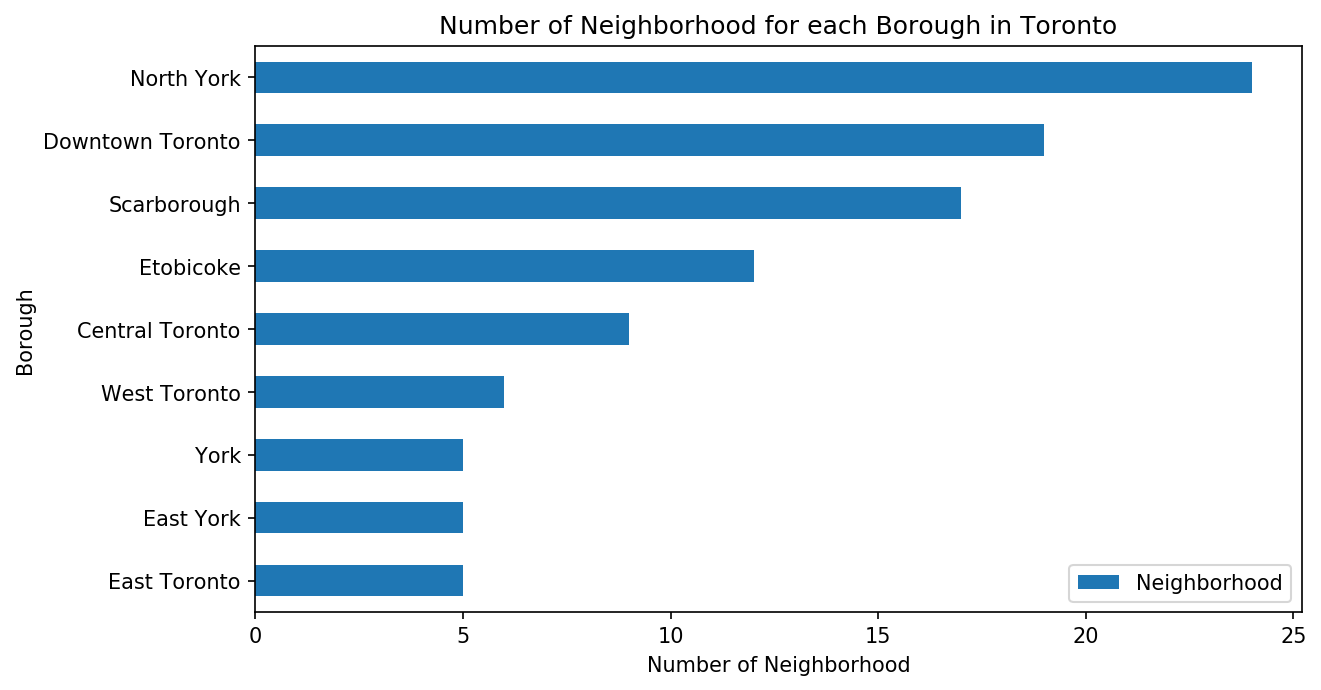

In [22]:
plt.figure(figsize=(9,5), dpi=150)
# title
plt.title('Number of Neighborhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Number of Neighborhood', fontsize = 10)
#On y-axis
plt.ylabel('Borough', fontsize=10)
#giving a bar plot
df_reqd_2.groupby('Borough')['Neighborhood'].count().sort_values().plot(kind='barh')
#legend
plt.legend()
#displays the plot
plt.show()

### North York has the maximum number of Neighborhood, followed by Downtown and Scarborough.

# Let us find out number of Indian Restaurants in Each Neighborhood.

In [23]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_toronto=pd.DataFrame(columns=column_names)
count=1
for row in df_reqd_2.values.tolist():
    Postcode, Borough, Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(df_reqd_2),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_toronto = indian_rest_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 102 ) Indian Resturants in Parkwoods, North York:1
( 2 / 102 ) Indian Resturants in Victoria Village, North York:2
( 3 / 102 ) Indian Resturants in Regent Park, Harbourfront, Downtown Toronto:0
( 4 / 102 ) Indian Resturants in Lawrence Manor, Lawrence Heights, North York:0
( 5 / 102 ) Indian Resturants in Queen's Park, Ontario Provincial Government, Downtown Toronto:1
( 6 / 102 ) Indian Resturants in Islington Avenue, Etobicoke:1
( 7 / 102 ) Indian Resturants in Malvern, Rouge, Scarborough:0
( 8 / 102 ) Indian Resturants in Don Mills, North York:0
( 9 / 102 ) Indian Resturants in Parkview Hill, Woodbine Gardens, East York:2
( 10 / 102 ) Indian Resturants in Garden District, Ryerson, Downtown Toronto:0
( 11 / 102 ) Indian Resturants in Glencairn, North York:0
( 12 / 102 ) Indian Resturants in West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale, Etobicoke:0
( 13 / 102 ) Indian Resturants in Rouge Hill, Port Union, Highland Creek, Scarborough:0
( 14 / 102 ) Indian

### How many Indian Restaurants did we get?
### Are there any null values?

In [30]:
print(indian_rest_toronto.shape)
print(indian_rest_toronto.isnull().sum())
indian_rest_toronto.head()

(118, 4)
Borough         0
Neighborhood    0
ID              0
Name            0
dtype: int64


,Borough,Neighborhood,ID,Name
0,North York,Parkwoods,4c27cddd9fb5d13a8cab9857,Patna Kebab House
1,North York,Victoria Village,4b9bccbef964a520ae2636e3,Sultan Of Samosas
2,North York,Victoria Village,4c27cddd9fb5d13a8cab9857,Patna Kebab House
3,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory
4,Etobicoke,Islington Avenue,4af1c64ff964a5200ae321e3,Chutneys Fine Indian Cuisine


### We have got 118 Indian Restaurants!

# Let us look Indian Restaurants in each Borough

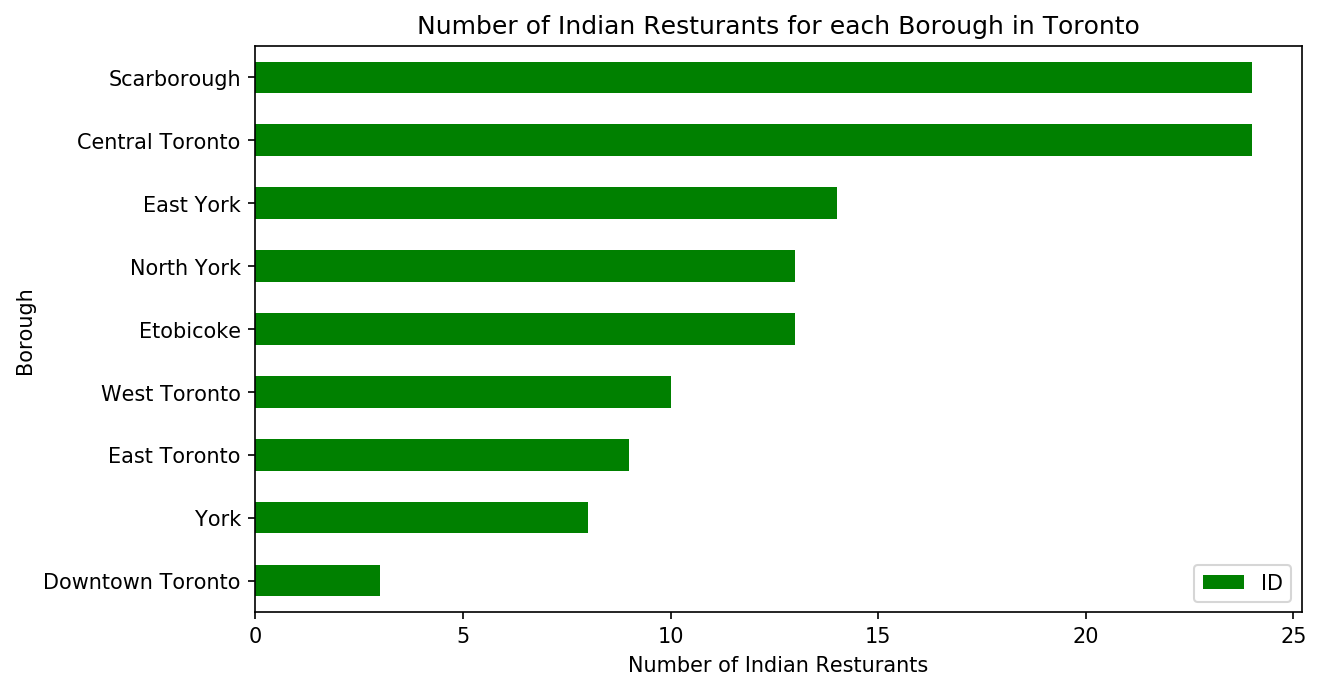

In [26]:
plt.figure(figsize=(9,5), dpi = 150)
# title
plt.title('Number of Indian Resturants for each Borough in Toronto')
#On x-axis
plt.xlabel('Number of Indian Resturants', fontsize = 10)
#On y-axis
plt.ylabel('Borough', fontsize=10)
#giving a bar plot
indian_rest_toronto.groupby('Borough')['ID'].count().sort_values().plot(kind='barh',color='Green')
#legend
plt.legend()
#displays the plot
plt.show()

### Scarborough and Central Toronto has the maximum number of Indian Restaurants, while Downtown has the least.
### Intersting! Lets dig more!!

### Which Neighborhood has the highest number of Indian Restaurants?

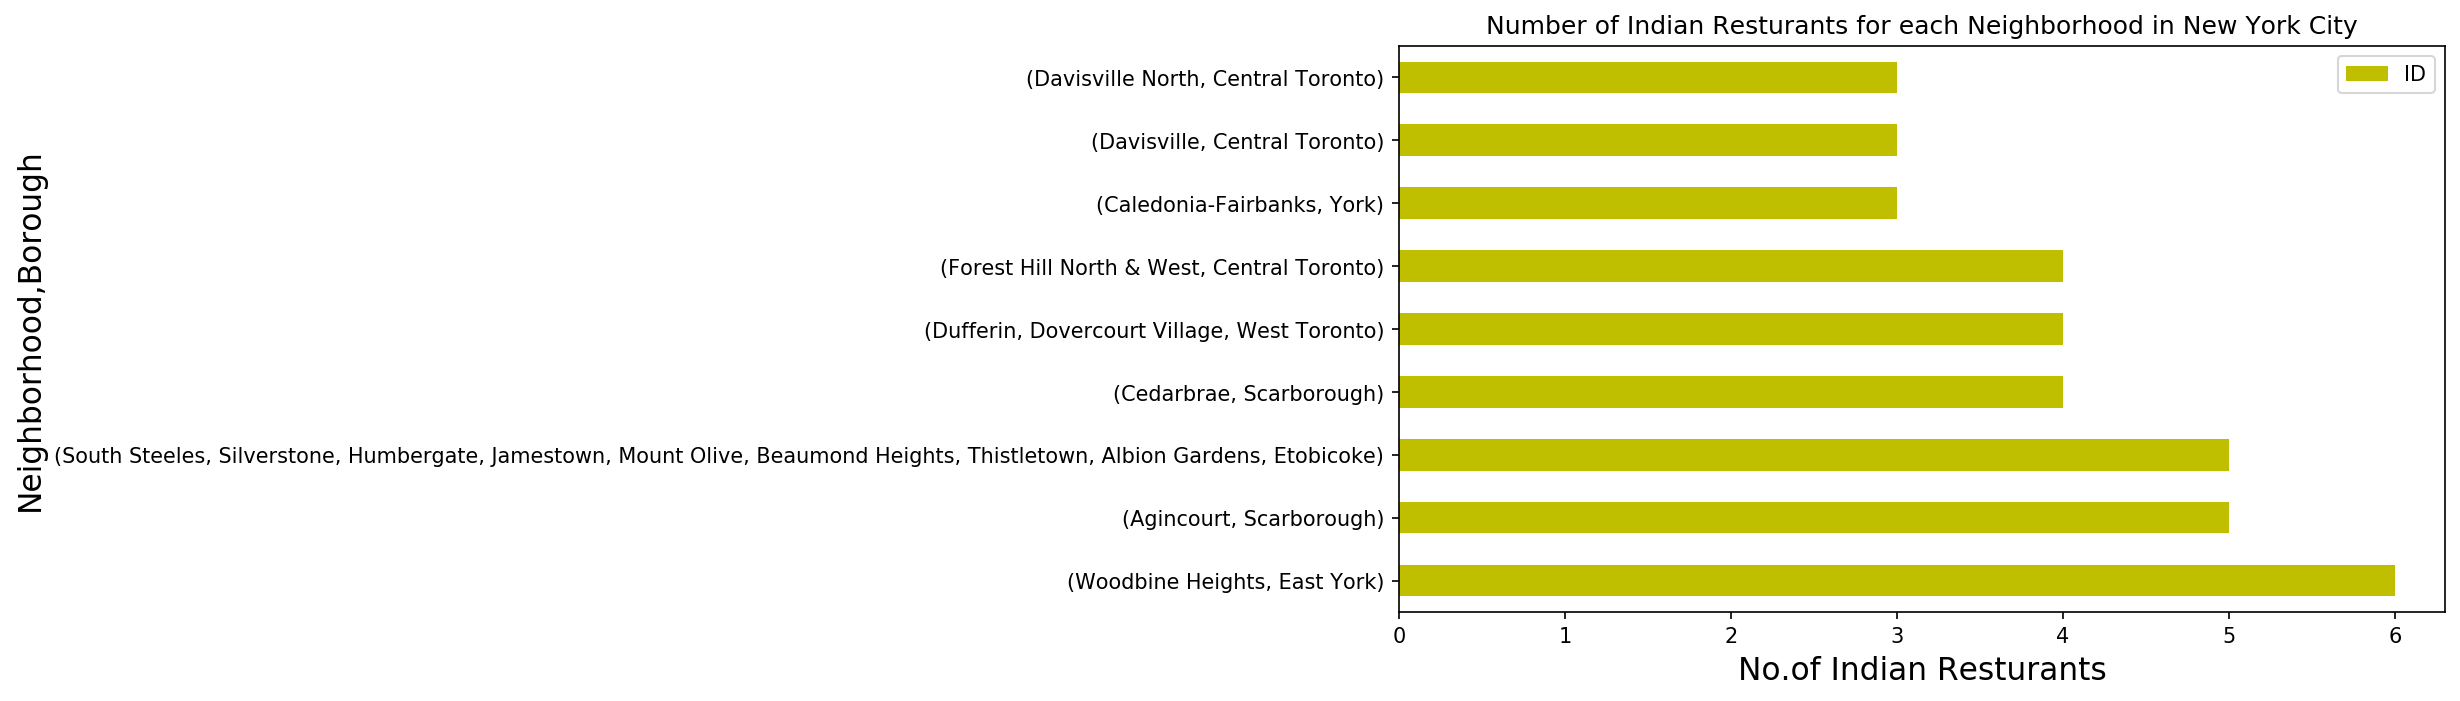

In [32]:

plt.figure(figsize=(9,5), dpi = 150)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('No.of Indian Resturants', fontsize = 15)
#On y-axis
plt.ylabel('Neighborhood', fontsize=15)
#giving a bar plot
#indian_rest_toronto.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='barh', color='y')
indian_rest_toronto.groupby(['Neighborhood','Borough'])['ID'].count().nlargest(9).plot(kind='barh', color='y')


#legend
plt.legend()
#displays the plot
plt.show()


### We can see that Woodbine, East York has the highest number of Indian Restaurants than any other Borough of Toronto.

### Lets find out the Indian Restaurants in East York.

In [33]:
rest_list_east=indian_rest_toronto[indian_rest_toronto['Borough']=='East York']
rest_list_east

,Borough,Neighborhood,ID,Name
5,East York,"Parkview Hill, Woodbine Gardens",4b9bccbef964a520ae2636e3,Sultan Of Samosas
6,East York,"Parkview Hill, Woodbine Gardens",507a19e5e4b0602b62f73d11,Faley Restaurant
9,East York,Woodbine Heights,4ae0c7a8f964a520638221e3,Udupi Palace
10,East York,Woodbine Heights,4b9bccbef964a520ae2636e3,Sultan Of Samosas
11,East York,Woodbine Heights,4afc9816f964a520312422e3,Motimahal
12,East York,Woodbine Heights,4daf08e66e81e2dffdd4fe40,Iqbal Kebab & Sweet Centre
13,East York,Woodbine Heights,4bac30a2f964a52018ea3ae3,Bombay Chowpatty
14,East York,Woodbine Heights,507a19e5e4b0602b62f73d11,Faley Restaurant
28,East York,Leaside,4b75c28af964a520ba222ee3,Kamasutra
29,East York,Leaside,4daf08e66e81e2dffdd4fe40,Iqbal Kebab & Sweet Centre


## Now let us get the Ranking of Each Restaurant based on Likes, Ratings, Tips from the FourSquare API.

In [34]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_toronto=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_toronto.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_toronto),')','processed')
    indian_rest_stats_toronto = indian_rest_stats_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID               Name  Likes  Rating  Tips
0  4c27cddd9fb5d13a8cab9857  Patna Kebab House      4     8.0     6
( 1 / 118 ) processed
                         ID               Name  Likes  Rating  Tips
0  4b9bccbef964a520ae2636e3  Sultan Of Samosas     29     8.6    24
( 2 / 118 ) processed
                         ID               Name  Likes  Rating  Tips
0  4c27cddd9fb5d13a8cab9857  Patna Kebab House      4     8.0     6
( 3 / 118 ) processed
                         ID                    Name  Likes  Rating  Tips
0  4c8c21fdf0ce236ab28e15ef  Butter Chicken Factory     18     8.4    10
( 4 / 118 ) processed
                         ID                          Name  Likes  Rating  Tips
0  4af1c64ff964a5200ae321e3  Chutneys Fine Indian Cuisine      5     6.9    10
( 5 / 118 ) processed
                         ID               Name  Likes  Rating  Tips
0  4b9bccbef964a520ae2636e3  Sultan Of Samosas     29     8.6    24
( 6 / 118 ) processed
                    

                         ID                          Name  Likes  Rating  Tips
0  4b8f4165f964a5205f4f33e3  Rajdhani Sweets & Restaurant      3     6.7     6
( 53 / 118 ) processed
                         ID             Name  Likes  Rating  Tips
0  4cead0ed9f776ea8bdcd6a22  Madras Dosa Hut      7     6.7     1
( 54 / 118 ) processed
                         ID         Name  Likes  Rating  Tips
0  4bca0625511f9521a6d0aec7  Brar Pakwan      4     6.3     2
( 55 / 118 ) processed
                         ID                                      Name  Likes  \
0  4b6dbc8ef964a520fd8a2ce3  Anjappar Authentic Chettinadu Restaurant     21   

   Rating  Tips  
0     8.2    10  
( 56 / 118 ) processed
                         ID                Name  Likes  Rating  Tips
0  51dde446498e8598c097f3d6  The Indian Cuisine      5     6.1     2
( 57 / 118 ) processed
                         ID          Name  Likes  Rating  Tips
0  4ae0c7a8f964a520638221e3  Udupi Palace     79     8.4    31
( 58 / 118

                         ID                    Name  Likes  Rating  Tips
0  5169d445e4b07de190b5c3d6  Marigold Indian Bistro     11     8.1    11
( 104 / 118 ) processed
                         ID                          Name  Likes  Rating  Tips
0  5557eeff498ea920bf32ab39  Tich - Modern Indian Cuisine     32     8.4     8
( 105 / 118 ) processed
                         ID                Name  Likes  Rating  Tips
0  4bc10d44abf49521d773c093  Bombay on the Lake      6     7.2     9
( 106 / 118 ) processed
                         ID                    Name  Likes  Rating  Tips
0  4c8baba11797236a141c6d88  Samosa & Sweet Factory     19     7.8     9
( 107 / 118 ) processed
                         ID           Name  Likes  Rating  Tips
0  4af45ad0f964a5209bf121e3  Tandoori Time      2     6.7     5
( 108 / 118 ) processed
                         ID                          Name  Likes  Rating  Tips
0  4b8f4165f964a5205f4f33e3  Rajdhani Sweets & Restaurant      3     6.7     6
( 109 

## We have got the data of Likes, Rating and Tips for each Indian Restaurant in Toronto, Canada.

### Let's move forward and see our data.

In [35]:
print('DataFrame has :',indian_rest_stats_toronto.shape[0],'rows and', indian_rest_stats_toronto.shape[1],'columns')
indian_rest_stats_toronto.head()

DataFrame has : 118 rows and 7 columns


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,North York,Parkwoods,4c27cddd9fb5d13a8cab9857,Patna Kebab House,4,8.0,6
1,North York,Victoria Village,4b9bccbef964a520ae2636e3,Sultan Of Samosas,29,8.6,24
2,North York,Victoria Village,4c27cddd9fb5d13a8cab9857,Patna Kebab House,4,8.0,6
3,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory,18,8.4,10
4,Etobicoke,Islington Avenue,4af1c64ff964a5200ae321e3,Chutneys Fine Indian Cuisine,5,6.9,10


## As we are using FourSquare API to fetch the details of each Indian Restaurants, it comes under Premium Call and has a Limit of 500 Calls/Day.
## So, let us save the DataFrame to a CSV File, and from here on we will use the CSV file for further manipulations.

In [36]:
indian_rest_stats_toronto.to_csv('indian_rest_stats_toronto.csv', index=False)
print('File Saved in your directory as indian_rest_stats_toronto.csv')

File Saved in your directory as indian_rest_stats_toronto.csv


## Loading the file.

In [37]:
indian_rest_stats_toronto_csv=pd.read_csv('indian_rest_stats_toronto.csv')
indian_rest_stats_toronto_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,North York,Parkwoods,4c27cddd9fb5d13a8cab9857,Patna Kebab House,4,8.0,6
1,North York,Victoria Village,4b9bccbef964a520ae2636e3,Sultan Of Samosas,29,8.6,24
2,North York,Victoria Village,4c27cddd9fb5d13a8cab9857,Patna Kebab House,4,8.0,6
3,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory,18,8.4,10
4,Etobicoke,Islington Avenue,4af1c64ff964a5200ae321e3,Chutneys Fine Indian Cuisine,5,6.9,10


## Check the type of varaibles and null values.

In [38]:
print(indian_rest_stats_toronto_csv.info())
print(indian_rest_stats_toronto_csv.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 7 columns):
Borough         118 non-null object
Neighborhood    118 non-null object
ID              118 non-null object
Name            118 non-null object
Likes           118 non-null int64
Rating          118 non-null float64
Tips            118 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 6.6+ KB
None
Borough         0
Neighborhood    0
ID              0
Name            0
Likes           0
Rating          0
Tips            0
dtype: int64


### Data types are correct and as per requirement for further analysis.

## Indian Restaurants based on MAX Likes.

In [39]:
print(indian_rest_stats_toronto_csv.iloc[indian_rest_stats_toronto_csv['Likes'].idxmax()])


Borough                         West Toronto
Neighborhood    Dufferin, Dovercourt Village
ID                  4adb969ef964a520332921e3
Name                  Banjara Indian Cuisine
Likes                                    142
Rating                                   8.8
Tips                                      75
Name: 40, dtype: object


## Indian Restaurants based on Highest Ratings.

In [40]:
print(indian_rest_stats_toronto_csv.iloc[indian_rest_stats_toronto_csv['Rating'].idxmax()])


Borough                             York
Neighborhood          Humewood-Cedarvale
ID              52418b0b7e48222eea81d2d2
Name                    Pukka Restaurant
Likes                                 41
Rating                                 9
Tips                                  26
Name: 15, dtype: object


## Indian Restaurants based on MAX Tips.

In [41]:
print(indian_rest_stats_toronto_csv.iloc[indian_rest_stats_toronto_csv['Tips'].idxmax()])

Borough                         West Toronto
Neighborhood    Dufferin, Dovercourt Village
ID                  4adb969ef964a520332921e3
Name                  Banjara Indian Cuisine
Likes                                    142
Rating                                   8.8
Tips                                      75
Name: 40, dtype: object


## Top Borough for Indian Restaurants based on Average Ratings.

In [42]:
toronto_borough_stats=indian_rest_stats_toronto_csv.groupby('Borough')['Rating'].mean().reset_index()
toronto_borough_stats.columns=['Borough','Average Rating']
toronto_borough_stats.nlargest(10,'Average Rating')

,Borough,Average Rating
1,Downtown Toronto,8.600000
7,West Toronto,8.360000
8,York,8.337500
0,Central Toronto,8.141667
2,East Toronto,8.011111
3,East York,7.814286
6,Scarborough,7.550000
4,Etobicoke,7.276923
5,North York,7.230769


### We can see that DownTown Toronto has the Best Indian Restaurants based on Average Ratings.

## Visualizing The Best of Borough.


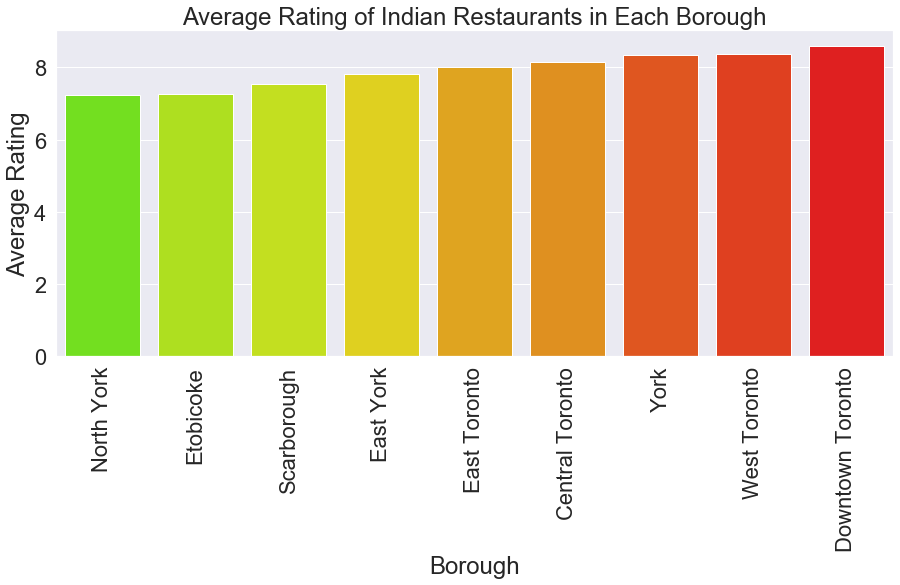

In [44]:
toronto_borough_stats=toronto_borough_stats.sort_values(by='Average Rating')
sns.set(style="darkgrid",font_scale=2,rc={'figure.figsize':(15,6)})
ax = sns.barplot(x="Borough", y="Average Rating", data=toronto_borough_stats, palette="prism_r")
plt.title('Average Rating of Indian Restaurants in Each Borough')
plt.xticks(rotation=90)
plt.show()

## Top Neighborhoods for Indian Restaurants based on Average Ratings.

In [119]:

toronto_neighborhood_stats=indian_rest_stats_toronto_csv.groupby(['Neighborhood'])['Rating'].mean().reset_index()
toronto_neighborhood_stats.columns=['Neighborhood','Average Rating']
toronto_neighborhood_stats.sort_values(by='Average Rating',ascending=False).head()



,Neighborhood,Average Rating
9,Christie,9.000000
46,"The Annex, North Midtown, Yorkville",9.000000
16,"Dufferin, Dovercourt Village",8.725000
45,"Summerhill West, Rathnelly, South Hill, Forest...",8.633333
20,"Golden Mile, Clairlea, Oakridge",8.600000


### We can see that Christie and The Annex has the Best Indian Restaurants based on Average Ratings.

## Visualizing The Best of Neighborhoods.
### Based on ratings above 8.0


In [102]:
avg_rating=8.0
best_toronto_neighborhood_stats=toronto_neighborhood_stats[toronto_neighborhood_stats['Average Rating']>=avg_rating]
print(best_toronto_neighborhood_stats.shape[0],'Indian Restaurants has average rating of', avg_rating, 'and above. \n Check the list below.')
best_toronto_neighborhood_stats.sort_values(by='Average Rating',ascending=False)

28 Indian Restaurants has average rating of 8.0 and above. 
 Check the list below.


,Neighborhood,Average Rating
9,Christie,9.000000
46,"The Annex, North Midtown, Yorkville",9.000000
16,"Dufferin, Dovercourt Village",8.725000
45,"Summerhill West, Rathnelly, South Hill, Forest...",8.633333
20,"Golden Mile, Clairlea, Oakridge",8.600000
23,Humewood-Cedarvale,8.433333
29,"Mimico NW, The Queensway West, South of Bloor,...",8.400000
38,Rosedale,8.400000
44,Studio District,8.400000
33,"Old Mill South, King's Mill Park, Sunnylea, Hu...",8.400000


## Merging DataFrame to get the Coordinates.

In [103]:
best_neighborhood_folium=pd.merge(best_toronto_neighborhood_stats,df_reqd_2,how='inner',on='Neighborhood')
best_neighborhood_folium=best_neighborhood_folium.rename(columns={'Borough_x':'Borough'})
best_neighborhood_folium=best_neighborhood_folium[['Borough','Neighborhood','Average Rating','Latitude','Longitude']]
print('We have our required DatFrame ready to be plotted on a Map.')
best_neighborhood_folium=best_neighborhood_folium.sort_values(by='Average Rating', ascending=False).reset_index(drop=True)
best_neighborhood_folium['Average Rating']=best_neighborhood_folium['Average Rating'].round(2)# set precision to 2 decimal place
best_neighborhood_folium

We have our required DatFrame ready to be plotted on a Map.


,Borough,Neighborhood,Average Rating,Latitude,Longitude
0,Downtown Toronto,Christie,9.00,43.669542,-79.422564
1,Central Toronto,"The Annex, North Midtown, Yorkville",9.00,43.672710,-79.405678
2,West Toronto,"Dufferin, Dovercourt Village",8.73,43.669005,-79.442259
3,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",8.63,43.686412,-79.400049
4,Scarborough,"Golden Mile, Clairlea, Oakridge",8.60,43.711112,-79.284577
5,York,Humewood-Cedarvale,8.43,43.693781,-79.428191
6,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",8.40,43.628841,-79.520999
7,Downtown Toronto,Rosedale,8.40,43.679563,-79.377529
8,East Toronto,Studio District,8.40,43.659526,-79.340923
9,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",8.40,43.636258,-79.498509


## Visualizing The Best of Neighborhoods based on Average Rating of 8.0 and above on Map.

In [121]:
best_neighborhood_avg_rating_map_1 = folium.Map(location=geo_location('Toronto'), zoom_start=10)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(best_neighborhood_avg_rating_map_1)

for lat, lng, rating, neighborhood in zip(best_neighborhood_folium['Latitude'], best_neighborhood_folium['Longitude'],best_neighborhood_folium['Average Rating'],best_neighborhood_folium['Neighborhood']):
    label = '{},{}'.format(rating,neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label).add_to(incidents)  
best_neighborhood_avg_rating_map_1.save('best_neighborhood_avg_rating_map_1.html')
best_neighborhood_avg_rating_map_1

### Link to map file: 

# Conclusion

- What is best location in Toronto for Indian Cuisine?
  - Banjara Indian Cuisine, Dufferin, West Toronto has the best Indian food.
- Which areas have potential Indian Restaurant Market?
  - North York, Etobicoke has the least rated Indian restaurants.
  - For an investor, it&#39;s an opportunity to grab to come up with high quality restaurant.
- Which all areas lack Indian Restaurants?
  - Downtown has the lowest number of Indian Restaurants but are highly rated.
  - For an investor, to come up with variety and quality is a challenge to conquer.
- Which is the best place to stay if I prefer Indian Cuisine?
  - West and Central Toronto are the places where one should stay if they prefer Indian Cuisine. These areas have quality and variety both.

# Limitation

- Food habits and likings are completely relative.
- Ranking of Borough, Neighborhood and Restaurants are based on ratings data fetched from FourSquare API.
- Results may vary if more data is available.

# Thank You

# Aayush Verma